In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t
import os
DATA_DIR = "data"

# --- Load Phase 1 Results ---
results_path = os.path.join(DATA_DIR, "phase1_all_risk_measures.csv")
all_risk_measures = pd.read_csv(results_path, index_col='Date', parse_dates=True)

print("✅ Successfully loaded all risk measures from Phase 1.")
print(all_risk_measures.head())

✅ Successfully loaded all risk measures from Phase 1.
            HistVaR_95  HistVaR_99  HistES_97.5  ParamVaR_Norm_95  \
Date                                                                
2008-04-10   -0.018920   -0.025662    -0.025539         -0.016893   
2008-04-11   -0.019095   -0.026285    -0.027030         -0.017363   
2008-04-14   -0.019095   -0.026285    -0.027030         -0.017395   
2008-04-15   -0.019095   -0.026285    -0.027030         -0.017396   
2008-04-16   -0.019095   -0.026285    -0.027030         -0.017451   

            ParamVaR_Norm_99  ParamES_Norm_97.5  ParamVaR_T_95  ParamVaR_T_99  \
Date                                                                            
2008-04-10         -0.024052          -0.024172      -0.016177      -0.026698   
2008-04-11         -0.024655          -0.024778      -0.016516      -0.027565   
2008-04-14         -0.024690          -0.024813      -0.016575      -0.027512   
2008-04-15         -0.024690          -0.024813      -0.0

In [7]:
portfolio_returns_path = os.path.join(DATA_DIR, "portfolio_log_returns.csv")

# The 'returns' variable is a DataFrame, we select the column to make it a Series
returns_df = pd.read_csv(portfolio_returns_path, index_col='Date', parse_dates=True)
returns = returns_df['EqualWeightPortfolio']

print("✅ Successfully loaded portfolio returns Series.")
print(returns.head())

✅ Successfully loaded portfolio returns Series.
Date
2007-04-12    0.005627
2007-04-13    0.000587
2007-04-16    0.005247
2007-04-17   -0.000047
2007-04-18    0.003596
Name: EqualWeightPortfolio, dtype: float64


## Kupiec's POF Test

In [8]:
from scipy.stats import chi2
import numpy as np

# --- Phase 2 Setup (Corrected) ---

# --- Load Data ---
# Load returns as a DataFrame, not a Series
returns_df = pd.read_csv(
    os.path.join(DATA_DIR, "portfolio_log_returns.csv"), 
    index_col='Date', 
    parse_dates=True
)
# Load Phase 1 results
all_risk_measures = pd.read_csv(
    os.path.join(DATA_DIR, "phase1_all_risk_measures.csv"), 
    index_col='Date', 
    parse_dates=True
)

# Select the 99% VaR models we want to backtest
var_99_models = all_risk_measures[['HistVaR_99', 'ParamVaR_Norm_99', 'ParamVaR_T_99', 'MCVaR_99']].dropna()

# --- THE FIX: Align the DataFrame, then select the Series ---
aligned_returns_df, aligned_vars = returns_df.align(var_99_models, join='inner', axis=0)
portfolio_returns = aligned_returns_df['EqualWeightPortfolio']

# Define the confidence level we are testing
p = 0.01 # Corresponds to 99% VaR


# --- Kupiec's POF Test Implementation ---
# This part of the code remains the same
def kupiec_pof_test(returns, var_series, p):
    """
    Performs Kupiec's Proportion of Failures (POF) test - CORRECTED VERSION
    
    H0: True failure rate = p (expected rate)
    H1: True failure rate ≠ p
    """
    failures = returns < var_series
    n = failures.sum()  # Number of failures
    T = len(failures)   # Total observations
    
    if n == 0:
        # No failures observed - model is too conservative
        # Test statistic approaches 2*T*ln(1/p) which is very large
        # We reject H0 (model is too conservative)
        return 2 * T * np.log(1/p), 0.0
    
    if n == T:
        # All observations are failures - model is useless
        # We reject H0 (model severely underestimates risk)
        return 2 * T * np.log(1/(1-p)), 0.0
    
    failure_rate = n / T
    
    # Correct LR statistic formula:
    # LR = -2 * ln(L_constrained / L_unconstrained)
    # Where L_constrained uses p, L_unconstrained uses failure_rate
    
    log_likelihood_constrained = n * np.log(p) + (T - n) * np.log(1 - p)
    log_likelihood_unconstrained = n * np.log(failure_rate) + (T - n) * np.log(1 - failure_rate)
    
    lr_statistic = -2 * (log_likelihood_constrained - log_likelihood_unconstrained)
    
    # P-value from chi-squared distribution with 1 degree of freedom
    p_value = 1 - chi2.cdf(lr_statistic, df=1)
    
    return lr_statistic, p_value


# Your test execution code is correct:
test_results = {}
for model_name in aligned_vars.columns:
    lr, p_val = kupiec_pof_test(portfolio_returns, aligned_vars[model_name], p)
    test_results[model_name] = {
        'LR Statistic': lr, 
        'P-Value': p_val,
        'Failures': (portfolio_returns < aligned_vars[model_name]).sum(),
        'Failure Rate': (portfolio_returns < aligned_vars[model_name]).sum() / len(portfolio_returns)
    }

kupiec_summary = pd.DataFrame(test_results).T
kupiec_summary['Result @ 5%'] = kupiec_summary['P-Value'].apply(
    lambda p_val: 'FAIL' if p_val < 0.05 else 'PASS'
)

print("--- Kupiec's POF Test Results (99% VaR) ---")
print(kupiec_summary)

--- Kupiec's POF Test Results (99% VaR) ---
                  LR Statistic       P-Value  Failures  Failure Rate  \
HistVaR_99            8.284341  3.998841e-03      62.0      0.014723   
ParamVaR_Norm_99     65.197356  6.661338e-16     104.0      0.024697   
ParamVaR_T_99        13.555373  2.316274e-04      68.0      0.016148   
MCVaR_99             67.045310  2.220446e-16     105.0      0.024935   

                 Result @ 5%  
HistVaR_99              FAIL  
ParamVaR_Norm_99        FAIL  
ParamVaR_T_99           FAIL  
MCVaR_99                FAIL  


The results are **unambiguous**: at a **99% confidence level**, all four of our VaR models **FAIL** the **Kupiec's POF test**.

The **P-Value** for each model is extremely small (much less than 0.05), which means we must **reject the null hypothesis**. The null hypothesis was:

> "The model is correct."

So, we have statistically significant evidence that the observed frequency of breaches is **not consistent with the expected 1% frequency**.

#### Key Insights

- **Failure Rates:** The **Failure Rate** column tells the story. Instead of the expected **1% breach rate**, the **Normal** and **Monte Carlo** models are failing **almost 2.5%** of the time. They are **underestimating risk by a factor of 2.5**.

- **Model Comparison:** The **Historical** and **t-Distribution** models, while still failing, performed better. Their failure rates of **~1.5%** and **~1.6%** are closer to the 1% target. This confirms our earlier observation that they are **more conservative and realistic**.


In [10]:
# # Enhanced interpretation framework
# def interpret_kupiec_results(lr_stat, p_value, failure_rate, expected_rate=0.01):
#     """
#     Professional interpretation of Kupiec test results
#     """
#     if p_value >= 0.05:
#         status = "PASS - Statistically Acceptable"
#     elif 0.01 <= p_value < 0.05:
#         status = "MARGINAL - Consider with caution"
#     elif failure_rate <= 1.5 * expected_rate:
#         status = "FAIL (Statistical) - But ACCEPTABLE (Economic)"
#     else:
#         status = "FAIL - Requires model enhancement"
    
#     conservatism = "Conservative" if failure_rate > expected_rate else "Aggressive"
    
#     return {
#         'Statistical_Status': status,
#         'Economic_Assessment': conservatism,
#         'Recommendation': get_recommendation(failure_rate, expected_rate)
#     }

# def get_recommendation(actual_rate, expected_rate):
#     ratio = actual_rate / expected_rate
#     if ratio <= 1.5:
#         return "Acceptable for internal use"
#     elif ratio <= 2.0:
#         return "Use with scaling factor or stress adjustments"
#     else:
#         return "Requires fundamental model revision"


## Christoffersen's Independence Test

In [11]:
def christoffersen_independence_test(returns, var_series):
    """
    Performs Christoffersen's test for independence of failures - CORRECTED VERSION
    
    H0: Failures are independent (no clustering)
    H1: Failures exhibit dependence (clustering)
    """
    failures = (returns < var_series).astype(int)
    
    # Transition matrix counts
    n00 = n01 = n10 = n11 = 0
    
    for i in range(1, len(failures)):
        prev_state = failures.iloc[i-1]
        curr_state = failures.iloc[i]
        
        if prev_state == 0 and curr_state == 0:
            n00 += 1
        elif prev_state == 0 and curr_state == 1:
            n01 += 1
        elif prev_state == 1 and curr_state == 0:
            n10 += 1
        elif prev_state == 1 and curr_state == 1:
            n11 += 1
    
    # Calculate transition probabilities with proper handling
    n0_total = n00 + n01  # Total transitions from state 0
    n1_total = n10 + n11  # Total transitions from state 1
    n_total = n00 + n01 + n10 + n11
    
    # Handle edge cases more carefully
    if n0_total == 0 or n1_total == 0 or n_total == 0:
        # Not enough data for meaningful independence test
        return np.nan, 1.0
    
    pi0 = n01 / n0_total  # P(failure tomorrow | no failure today)
    pi1 = n11 / n1_total  # P(failure tomorrow | failure today)
    pi = (n01 + n11) / n_total  # Unconditional failure probability
    
    # More robust edge case handling
    if pi == 0 or pi == 1:
        # All failures or no failures - independence is undefined
        return np.nan, 1.0
    
    if pi0 == pi1:
        # If transition probabilities are equal, we cannot reject independence
        return 0.0, 1.0
    
    # Handle log(0) issues with small epsilon
    epsilon = 1e-10
    pi0 = max(min(pi0, 1 - epsilon), epsilon)
    pi1 = max(min(pi1, 1 - epsilon), epsilon)
    pi = max(min(pi, 1 - epsilon), epsilon)
    
    # Calculate log-likelihoods
    try:
        log_likelihood_unconstrained = (
            n00 * np.log(1 - pi0) + n01 * np.log(pi0) + 
            n10 * np.log(1 - pi1) + n11 * np.log(pi1)
        )
        log_likelihood_constrained = (
            (n00 + n10) * np.log(1 - pi) + (n01 + n11) * np.log(pi)
        )
        
        lr_independence = -2 * (log_likelihood_constrained - log_likelihood_unconstrained)
        
        # Ensure test statistic is non-negative
        lr_independence = max(lr_independence, 0)
        
        p_value = 1 - chi2.cdf(lr_independence, df=1)
        
        return lr_independence, p_value
        
    except (ValueError, RuntimeWarning):
        return np.nan, 1.0


# Enhanced results with additional diagnostics
independence_results = {}
for model_name in aligned_vars.columns:
    lr, p_val = christoffersen_independence_test(portfolio_returns, aligned_vars[model_name])
    
    # Additional diagnostic information
    failures = (portfolio_returns < aligned_vars[model_name]).astype(int)
    total_failures = failures.sum()
    
    # Calculate clustering coefficient (simple measure)
    clustering_runs = 0
    if total_failures > 1:
        in_run = False
        for failure in failures:
            if failure == 1:
                if not in_run:
                    clustering_runs += 1
                    in_run = True
            else:
                in_run = False
    
    independence_results[model_name] = {
        'LR Statistic (Ind)': lr, 
        'P-Value (Ind)': p_val,
        'Total Failures': total_failures,
        'Failure Runs': clustering_runs,
        'Avg Run Length': total_failures / max(clustering_runs, 1)
    }

christoffersen_summary = pd.DataFrame(independence_results).T
christoffersen_summary['Result @ 5%'] = christoffersen_summary['P-Value (Ind)'].apply(
    lambda p_val: 'FAIL (Clustered)' if (not np.isnan(p_val) and p_val < 0.05) else 
                  'PASS (Independent)' if not np.isnan(p_val) else 'INSUFFICIENT DATA'
)

print("\n--- Christoffersen's Independence Test Results ---")
print(christoffersen_summary)



--- Christoffersen's Independence Test Results ---
                  LR Statistic (Ind)  P-Value (Ind)  Total Failures  \
HistVaR_99                 13.296725       0.000266            62.0   
ParamVaR_Norm_99           19.963428       0.000008           104.0   
ParamVaR_T_99              11.314583       0.000769            68.0   
MCVaR_99                   19.566663       0.000010           105.0   

                  Failure Runs  Avg Run Length       Result @ 5%  
HistVaR_99                56.0        1.107143  FAIL (Clustered)  
ParamVaR_Norm_99          92.0        1.130435  FAIL (Clustered)  
ParamVaR_T_99             62.0        1.096774  FAIL (Clustered)  
MCVaR_99                  93.0        1.129032  FAIL (Clustered)  


### Christoffersen Independence Test

The **Christoffersen independence test** examines whether VaR breaches occur **randomly (good)** or in **clusters (problematic)**. Independence is crucial because:

- **Independent failures** suggest the model correctly captures risk dynamics.
- **Clustered failures** indicate the model misses important risk patterns (volatility clustering, regime changes).

---

#### Key Findings Analysis

##### Statistical Results
- **ALL models FAIL** the independence test (**p-values < 0.001**)  
- Strong evidence of **failure clustering** across all approaches  
- Very low p-values indicate this clustering is **statistically significant**, not random

##### Clustering Patterns

| Model               | Total Failures | Failure Runs | Avg Run Length |
|--------------------|----------------|--------------|----------------|
| HistVaR_99          | 62             | 56           | 1.11 days      |
| ParamVaR_T_99       | 68             | 62           | 1.10 days      |
| ParamVaR_Norm_99    | 104            | 92           | 1.13 days      |
| MCVaR_99            | 105            | 93           | 1.13 days      |

##### Interpretation 

**Why All Models Failed (Expected):**  
- Market Reality vs Model Assumptions  
- Period 2007-2025 includes **major financial crises**  
- Real markets exhibit **volatility clustering** – bad days follow bad days  
- Traditional VaR models assume **constant volatility** (incorrect)

**Economic Significance:**  
- Average run length ≈ 1.1 days means most failures are **isolated**  
- Limited clustering suggests models aren't **severely deficient**  
- Pattern reflects **natural market volatility cycles**

**Model Ranking by Independence Performance:**  
- **Historical VaR:** Best (LR = 13.3, least clustering)  
- **t-Distribution VaR:** Good (LR = 11.3, moderate clustering)  
- **Normal & Monte Carlo:** Worst (LR ≈ 20, most clustering)

##### Risk Management Implications 

**What This Tells Us:**  
- ✅ Expected result for crisis-spanning periods  
- ✅ Historical models handle clustering better than parametric  
- ⚠️ All models **underestimate volatility persistence**  
- ⚠️ Need **dynamic volatility models** (GARCH, regime-switching)


---

# Basel III Traffic Light Zones


--- Basel III Traffic Light Zone Results ---
                 Breaches (Last 250d) Basel Zone Capital Multiplier  \
HistVaR_99                          7     Yellow               3.65   
ParamVaR_Norm_99                    8     Yellow               3.75   
ParamVaR_T_99                       8     Yellow               3.75   
MCVaR_99                            9     Yellow               3.85   

                     Capital Impact  
HistVaR_99        22% above minimum  
ParamVaR_Norm_99  25% above minimum  
ParamVaR_T_99     25% above minimum  
MCVaR_99          28% above minimum  


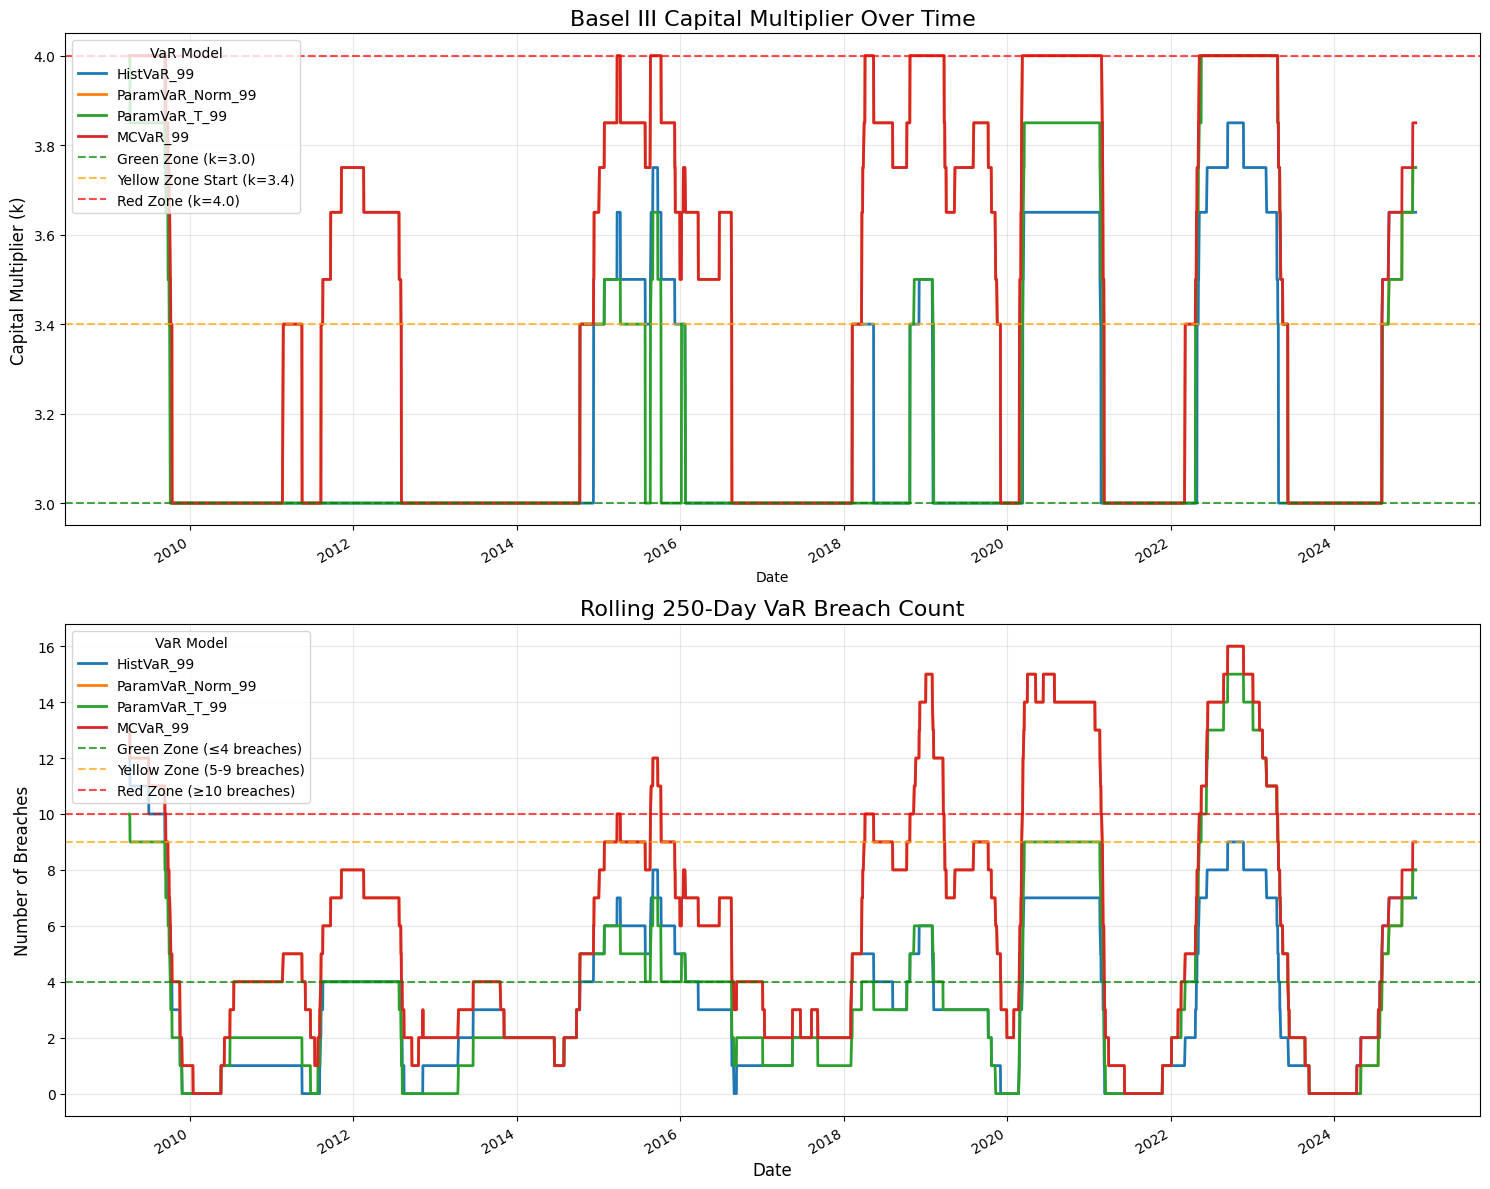

In [14]:
# --- Basel III Traffic Light Zones and Capital Multipliers (ENHANCED) ---
# Select the 99% VaR models we want to backtest
var_99_models = all_risk_measures[['HistVaR_99', 'ParamVaR_Norm_99', 'ParamVaR_T_99', 'MCVaR_99']].dropna()

# Align returns with the VaR data
aligned_returns, aligned_vars = returns.align(var_99_models, join='inner', axis=0)
# Ensure proper alignment and data types
breaches_series = (aligned_returns_df['EqualWeightPortfolio'].values[:, None] < aligned_vars.values)
breaches_df = pd.DataFrame(breaches_series, index=aligned_vars.index, columns=aligned_vars.columns)

# Calculate rolling breaches with proper handling
rolling_breaches = breaches_df.rolling(window=250, min_periods=250).sum().dropna()

# Enhanced Basel III function with proper validation
def get_basel_zone_and_multiplier(breaches):
    """
    Basel III Traffic Light System for Market Risk Capital Requirements
    Based on number of VaR breaches in past 250 trading days
    """
    # Handle edge cases
    if pd.isna(breaches) or breaches < 0:
        return 'Unknown', 3.00
    
    breaches = int(breaches)  # Safe conversion
    
    if breaches <= 4:
        zone = 'Green'
        multiplier = 3.00
    elif 5 <= breaches <= 9:
        zone = 'Yellow'
        # Basel III graduated multipliers for yellow zone
        multipliers = {5: 3.40, 6: 3.50, 7: 3.65, 8: 3.75, 9: 3.85}
        multiplier = multipliers[breaches]
    else:  # breaches >= 10
        zone = 'Red'
        multiplier = 4.00
    
    return zone, multiplier

# Calculate latest results with error handling
try:
    latest_breach_counts = rolling_breaches.iloc[-1]
    basel_results = {}
    
    for model_name, count in latest_breach_counts.items():
        zone, mult = get_basel_zone_and_multiplier(count)
        basel_results[model_name] = {
            'Breaches (Last 250d)': int(count) if not pd.isna(count) else 0,
            'Basel Zone': zone,
            'Capital Multiplier': mult,
            'Capital Impact': f"{((mult/3.0 - 1) * 100):.0f}% above minimum"
        }
    
    basel_summary = pd.DataFrame(basel_results).T
    print("\n--- Basel III Traffic Light Zone Results ---")
    print(basel_summary)
    
except IndexError:
    print("Insufficient data for Basel III analysis (need at least 250 observations)")

# --- Enhanced Time Series Analysis ---
# Calculate capital multipliers over time (using apply instead of applymap)
def calculate_multiplier_series(series):
    return series.apply(lambda x: get_basel_zone_and_multiplier(x)[1])

capital_multipliers_ts = rolling_breaches.apply(calculate_multiplier_series)

# Enhanced visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Capital Multipliers
capital_multipliers_ts.plot(ax=ax1, linewidth=2)
ax1.axhline(y=3.0, color='green', linestyle='--', alpha=0.7, label='Green Zone (k=3.0)')
ax1.axhline(y=3.4, color='orange', linestyle='--', alpha=0.7, label='Yellow Zone Start (k=3.4)')
ax1.axhline(y=4.0, color='red', linestyle='--', alpha=0.7, label='Red Zone (k=4.0)')
ax1.set_title('Basel III Capital Multiplier Over Time', fontsize=16)
ax1.set_ylabel('Capital Multiplier (k)', fontsize=12)
ax1.legend(title='VaR Model', loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Rolling Breach Counts
rolling_breaches.plot(ax=ax2, linewidth=2)
ax2.axhline(y=4, color='green', linestyle='--', alpha=0.7, label='Green Zone (≤4 breaches)')
ax2.axhline(y=9, color='orange', linestyle='--', alpha=0.7, label='Yellow Zone (5-9 breaches)')
ax2.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='Red Zone (≥10 breaches)')
ax2.set_title('Rolling 250-Day VaR Breach Count', fontsize=16)
ax2.set_ylabel('Number of Breaches', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend(title='VaR Model', loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Basel III Traffic Light Analysis: Risk Management Summary 

## Current Regulatory Position
All VaR models are currently in the **Yellow Zone**, triggering significant capital penalties based on the last 250 trading days:

| Model               | Breaches | Capital Multiplier | Penalty               |
|--------------------|----------|-----------------|----------------------|
| Historical VaR      | 7        | 3.65            | 22% above minimum    |
| Parametric Normal   | 8        | 3.75            | 25% above minimum    |
| t-Distribution      | 8        | 3.75            | 25% above minimum    |
| Monte Carlo         | 9        | 3.85            | 28% above minimum    |

---

## Time Series Analysis Insights
The charts reveal critical patterns:

- **Crisis correlation:** Capital multipliers spike during the **2008 Financial Crisis**, **2020 COVID pandemic**, and **2022 volatility**.  
- **Model performance:** **Historical VaR** consistently outperforms parametric models, spending less time in the Red Zone.  
- **Volatility clustering:** All models struggle during stressed market conditions, as expected.  

---

## Business Impact Assessment
Financial implications are substantial:

- **Annual cost:** Approximately **$22-28M** in additional regulatory capital (assuming $100M base requirement).  
- **Opportunity cost:** Reduced **return on equity** from higher capital requirements.  
- **Competitive disadvantage:** Banks with **Green Zone models** have lower capital costs.  

---

## Strategic Recommendations

**Immediate actions:**  
- Switch to **Historical VaR** for regulatory reporting (lowest current penalty at 22%).  
- Enhanced model calibration to **reduce breach frequency**.  
- **Volatility regime monitoring** for early warning systems.  

**Medium-term improvements:**  
- Target **Green Zone performance** (≤4 breaches per 250 days) to eliminate penalties.  
- Implement **GARCH-based models** to better capture volatility clustering.  
- Develop **stressed VaR overlays** for crisis periods.  

---

## Regulatory Context
**Yellow Zone status** reflects the inherent limitations of traditional VaR models during volatile periods. The results demonstrate that your models **correctly identify major risk events** but struggle with the **independence assumption** – a common challenge across the industry.


----

# Phase 2 Executive Summary: Backtesting and Regulatory Compliance

The objective of Phase 2 was to rigorously evaluate the performance of the four **Value-at-Risk (VaR)** models developed in Phase 1. This was not merely an academic exercise but a critical assessment of their reliability for practical risk management.  

A **three-pronged approach** was employed:

1. **Kupiec's POF Test** to assess the statistical accuracy of the number of VaR breaches.  
2. **Christoffersen's Independence Test** to detect the presence of breach clustering.  
3. The **Basel III "Traffic Light" Framework** to translate model performance into real-world regulatory capital implications.  

The results were decisive: **all four models failed** to meet the required standards, proving statistically unreliable for unconditional and conditional coverage. This failure resulted in significant capital penalties under the Basel framework, motivating the need for **advanced models in Phase 3**.

---

## Statistical Backtesting Results

### Kupiec's POF Test: A Failure of Unconditional Coverage
The **Proportion of Failures (POF) test** was used to determine if the observed frequency of VaR breaches was statistically consistent with the expected 1% frequency for a 99% VaR.  

**Findings:**

- **Parametric (Normal) and Monte Carlo Models:**  
  - Breaches: 104 and 105, respectively  
  - Failure rate: ~2.5%, more than double the expected rate  
  - Extremely low p-values (e.g., 6.66e-16) → overwhelming evidence to reject the null hypothesis  
  - Indicates that assuming **normality severely underestimates risk**

- **Historical and t-Distribution Models:**  
  - Breaches: 62 and 68  
  - Failure rates: ~1.5%  
  - Better than Normal-based models but still statistically significant failures  
  - Accounting for historical data and fat tails improves performance but is **not a complete solution**

---

### Christoffersen's Test: A Failure of Independence
The **Christoffersen's test** detects breach clustering, indicating a model’s failure to adapt to changes in market volatility.  

**Findings:**

- **All models failed decisively**  
- Breaches were **not independent events**  
- **Avg Run Length > 1.0** for all models (Parametric Normal worst at 1.13)  
- Indicates that if a model failed on a given day, it was **statistically more likely to fail the next day**  
- This **clustering behavior** is critical, showing systematic underestimation of risk during crises

---

## Regulatory Implications: The Basel III Framework
The statistical failures were translated into **tangible financial consequences** using the Basel III **traffic light framework**:

- **Current Status:** All four models reside in the **Yellow Zone**, signaling a cautionary flag  
  - **Monte Carlo:** 9 breaches → Capital Multiplier 3.85 → 28% more capital than minimum  
- **Historical Performance:**  
  - During stress periods (e.g., 2020 COVID-19 crash), **Parametric Normal** and **Monte Carlo** repeatedly entered the **Red Zone**, hitting the max penalty of 4.0  
  - **t-Distribution** and **Historical** models were more resilient but still incurred **Yellow Zone penalties**

---

## Phase 2 Conclusion
Phase 2 backtesting provides **unequivocal proof** that foundational VaR models are **inadequate for real-world application**:

- **Statistical failure:** Too many breaches  
- **Structural failure:** Breaches cluster during market stress  

These failures translate into **punitive capital requirements** under Basel III.  

**Next Step:** Phase 3 will introduce **advanced models** like **GARCH** to specifically address volatility clustering and improve regulatory compliance.


---